In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from sklearn.model_selection import KFold, cross_validate, train_test_split, GridSearchCV, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, log_loss, make_scorer
from sklearn.utils import shuffle
from cf_matrix import make_confusion_matrix
import random
import pickle
import sys
from PositionClassifier import PositionClassifier
sys.path.append('../../')
from utils.model import get_positions

def correlation_matrix(df, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df.corr(), vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show()

In [3]:
df = pd.read_csv('../3_merge_features_and_positions/data/data.csv')
print(df.shape)
df.head()

(3710, 40)


,name,id,x,y,left,right,min_hull_left,min_hull_right,up,down,...,up_defensive,bottom_defensive,def_actions,y_deviation,x_deviation,x_bin,y_bin,posadj_hull_x,posadj_hull_y,position
0,Riccardo Orsolini,286828.0,52.469118,11.530000,0.666667,0.333333,0.888889,0.111111,0.888889,0.111111,...,1.000000,0.000000,0.583333,0.883733,0.282115,4,0,30.345,15.572,RW
1,Nicolás Domínguez,334653.0,48.375000,39.556571,0.555556,0.444444,0.555556,0.444444,0.333333,0.666667,...,0.444444,0.555556,0.416667,-0.000000,0.467163,3,2,33.180,29.852,CM
2,Takehiro Tomiyasu,377283.0,33.618750,46.048143,0.111111,0.888889,0.222222,0.777778,0.222222,0.777778,...,0.222222,0.777778,0.416667,-0.170636,0.746966,1,3,22.050,20.332,CB
3,Roberto Soriano,78906.0,52.906452,30.696516,0.777778,0.222222,0.777778,0.222222,0.666667,0.333333,...,0.777778,0.222222,0.333333,0.430707,0.324499,4,1,38.640,39.372,CM
4,Danilo,18727.0,24.546000,25.560229,0.000000,1.000000,0.000000,1.000000,0.777778,0.222222,...,0.666667,0.333333,0.166667,0.000000,1.000000,2,1,35.595,28.764,CB


In [4]:
df = df.dropna()
df.index = np.arange(0, df.shape[0])
train_columns = [
     'right',
     'up',
     'local_right',
     'local_up',
     'angle',
     'hull_top',
     'hull_bottom',
     'centrality',
     'avg_pass_length',
     'avg_pass_angle',
     'avg_receival_angle',
     'def_actions',
     'min_hull_left',
     'min_hull_right',
     'y_deviation',
     'x_deviation',
     'up_defensive',
     'right_defensive',
     'x_bin',
     'y_bin'
]

X = df[train_columns]
y = df[['position']]
classes = sorted(y['position'].unique())

y['position'].value_counts()

CM    1025
CB     884
ST     496
LB     373
RB     370
LW     279
RW     275
Name: position, dtype: int64

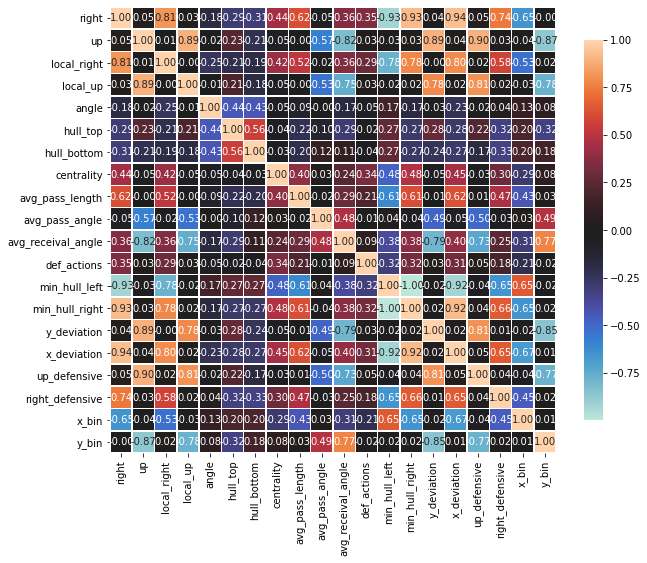

In [7]:
correlation_matrix(X)

# FINE TUNING

In [5]:
from genetuning import GeneTuning, Param

brain = xgboost.XGBClassifier(objective='multi:softmax')
params = dict(
    learning_rate=Param([0.1, 0.01, 0.001]),
    gamma=Param([0.01, 0.1, 0.3, 0.5, 1, 1.5, 2]),
    max_depth=Param([2, 4, 7, 10], True),
    subsample=Param([0.2, 0.4, 0.5, 0.6, 0.7]),
    colsample_bytree=Param([0.3, 0.6, 0.8, 1.0]),
    min_child_weight=Param([1, 3, 5, 7], True),
    n_estimators=Param([100, 250, 500, 1000], True),
    reg_alpha=Param([0, 0.5, 1]),
    reg_lambda=Param([1, 1.5, 2, 3, 4.5])
)

gt = GeneTuning(brain, params, parents_num=4, children_num=4, population_size_init=20, cv=10, generations_num=20)
gt.fit(X, y)
print('\n\nACCURACY: ', gt.best_score)
print('BEST PARAMS:', gt.best_params)

# {'learning_rate': 0.1, 'gamma': 1.5, 'max_depth': 7, 'subsample': 0.6, 'colsample_bytree': 0.3, 'min_child_weight': 5, 'n_estimators': 500, 'reg_alpha': 0.5, 'reg_lambda': 1.5}

Generation  1 / 20 :
Fitting model 1 / 20 :  {'learning_rate': 0.1, 'gamma': 0.3, 'max_depth': 7, 'subsample': 0.6, 'colsample_bytree': 0.8, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 3.0}  : 0.8793781237985391
Fitting model 2 / 20 :  {'learning_rate': 0.1, 'gamma': 1.0, 'max_depth': 10, 'subsample': 0.7, 'colsample_bytree': 0.8, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 2.0}  : 0.8800641580161477
Fitting model 3 / 20 :  {'learning_rate': 0.001, 'gamma': 1.5, 'max_depth': 2, 'subsample': 0.5, 'colsample_bytree': 1.0, 'min_child_weight': 7, 'n_estimators': 500, 'reg_alpha': 1.0, 'reg_lambda': 1.5}  : 0.8388011822376008
Fitting model 4 / 20 :  {'learning_rate': 0.001, 'gamma': 1.5, 'max_depth': 7, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 7, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.5}  : 0.8554450211457132
Fitting model 5 / 20 :  {'learning_rate': 0.01, 'gamma': 0.5, 'max_depth': 2, 'sub

KeyboardInterrupt: 

# CROSS VAL EVALUATION

In [8]:
brain = xgboost.XGBClassifier(
    objective='multi:softmax',
    colsample_bytree=0.5,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.5,
    min_child_weight=1,
    n_estimators=450
)
kfold = KFold(n_splits=10)
scorers = {'accuracy': 'accuracy',
           'log_loss': make_scorer(log_loss, labels=classes, needs_proba=True)}

n = 5
accs, lls = [], []
for i in range(0, n):
    X, y = shuffle(X, y)
    results = cross_validate(brain, X, y, scoring=scorers, cv=kfold)
    acc = results['test_accuracy'].mean()
    ll = results['test_log_loss'].mean()
    accs.append(acc)
    lls.append(ll)

    print(f"Iteration {i+1}. Acc: {np.round(acc*100, 2)}% - Log Loss: {np.round(ll, 5)}")

print(f"OVERALL. Acc: {np.round(np.mean(accs)*100, 2)}% - Log Loss: {np.round(np.mean(lls), 5)}")

Iteration 1. Acc: 87.66% - Log Loss: 0.36335
Iteration 2. Acc: 87.9% - Log Loss: 0.36491
Iteration 3. Acc: 87.74% - Log Loss: 0.36142


KeyboardInterrupt: 

# CONFUSION MATRIX

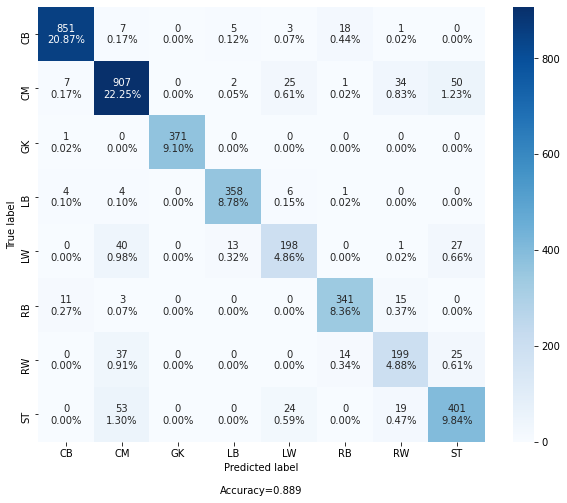

In [5]:
kfold = KFold(n_splits=10, random_state=7)
y_pred = cross_val_predict(brain, X, y, cv=kfold)

cf = confusion_matrix(y, y_pred)
make_confusion_matrix(cf, figsize=[10, 8], categories=classes)

# FEATURE IMPORTANCES

In [8]:
brain.fit(
    X=df[train_columns],
    y=df[['position']]
)
feature_importances = dict(zip(train_columns, brain.feature_importances_))
sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

[('right', 0.14600557),
 ('up', 0.12305214),
 ('min_hull_right', 0.11541929),
 ('y_deviation', 0.09871035),
 ('min_hull_left', 0.09200016),
 ('x_deviation', 0.07497675),
 ('local_right', 0.066059664),
 ('local_up', 0.06509206),
 ('avg_receival_angle', 0.038078606),
 ('angle', 0.036870223),
 ('up_defensive', 0.02913161),
 ('hull_top', 0.022435075),
 ('centrality', 0.020715265),
 ('hull_bottom', 0.017908854),
 ('right_defensive', 0.014471064),
 ('avg_pass_length', 0.013795741),
 ('avg_pass_angle', 0.012682679),
 ('def_actions', 0.012594951)]

# ADJUSTING PREDS WITH GENETUNING

In [5]:
def team_kfold(df, n_splits, random_state=0):
    df['id'] = df['filename'] + '_' + df['team_name']
    teams = df['id'].unique()
    
    random.seed(random_state)
    random.shuffle(teams)

    folds = np.array_split(teams, n_splits)
    folds_idx = []
    for fold in folds:
        folds_idx.append(np.array(df.loc[df['id'].isin(fold)].index))

    train_indices = []
    leave_out_idx = 0
    for i in range(0, n_splits):
        local_tmp = []
        for j in range(0, n_splits):
            if leave_out_idx != j:
                local_tmp.append(folds_idx[j])

        train_indices.append(np.concatenate(local_tmp))
        leave_out_idx += 1

    train_indices = np.array(train_indices)
    test_indices = folds_idx

    return zip(train_indices, test_indices)

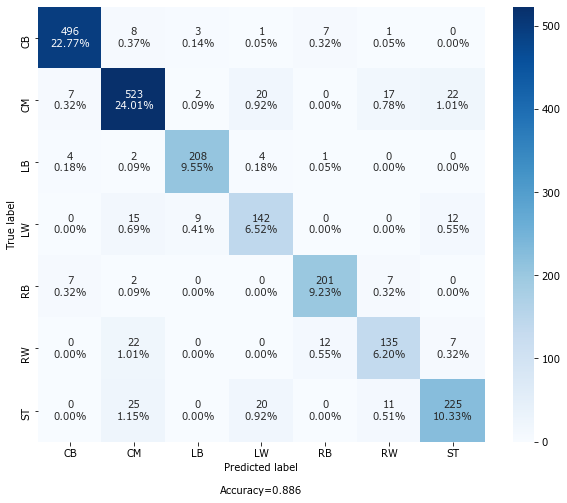

In [72]:
brain = xgboost.XGBClassifier(
    objective='multi:softmax',
    colsample_bytree=0.5,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.5,
    min_child_weight=1,
    n_estimators=450
)

kfold = team_kfold(df, n_splits=5, random_state=7)
y_pred = cross_val_predict(brain, X, y, cv=kfold)

cf = confusion_matrix(y, y_pred)
make_confusion_matrix(cf, figsize=[10, 8], categories=classes)

In [6]:
pos_classifier = PositionClassifier()

kfold = team_kfold(df, n_splits=10, random_state=7)
y_pred = cross_val_predict(pos_classifier, X, y, cv=kfold)

           LW
4       ST             ST
5       RW             RW
6       LW             LB
7       CB             CB
8       CM             CM
9       CM             CM
Generation 100/1000 	 Max Score: 176.86 	 Max Score Iter: 35
Generation 200/1000 	 Max Score: 690.09 	 Max Score Iter: 173
Generation 300/1000 	 Max Score: 690.09 	 Max Score Iter: 173
Generation 400/1000 	 Max Score: 709.41 	 Max Score Iter: 321
Generation 500/1000 	 Max Score: 722.46 	 Max Score Iter: 478
Generation 600/1000 	 Max Score: 722.46 	 Max Score Iter: 478
Generation 700/1000 	 Max Score: 722.46 	 Max Score Iter: 478
n_iter: 779, score: 722.4583358764648


Fixed: 1
  position fixed_position
0       RB             RB
1       LB             LB
2       CB             CB
3       LW             LW
4       CM             CM
5       ST             ST
6       CM             RW
7       CB             CB
8       CB             CB
9       CM             CM
Generation 100/1000 	 Max Score: 271.96 	 Max Score Iter: 95
G

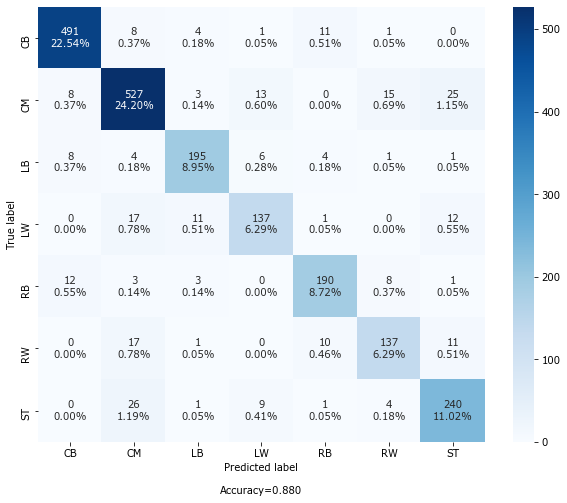

In [7]:
cf = confusion_matrix(y, y_pred)
make_confusion_matrix(cf, figsize=[10, 8], categories=classes)

# SAVE MODEL

In [14]:
X, y = shuffle(X, y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)
brain = xgboost.XGBClassifier(
    objective='multi:softmax',
    colsample_bytree=0.5,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.5,
    min_child_weight=1,
    n_estimators=10000
)
brain.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=['mlogloss'],
    early_stopping_rounds=1,
    verbose=True
)

with open('brain.xgb', 'wb') as handle:
    pickle.dump(brain, handle)

validation_0-mlogloss:0.25137
[7206]	validation_0-mlogloss:0.25136
[7207]	validation_0-mlogloss:0.25135
[7208]	validation_0-mlogloss:0.25134
[7209]	validation_0-mlogloss:0.25133
[7210]	validation_0-mlogloss:0.25132
[7211]	validation_0-mlogloss:0.25131
[7212]	validation_0-mlogloss:0.25130
[7213]	validation_0-mlogloss:0.25128
[7214]	validation_0-mlogloss:0.25127
[7215]	validation_0-mlogloss:0.25126
[7216]	validation_0-mlogloss:0.25125
[7217]	validation_0-mlogloss:0.25123
[7218]	validation_0-mlogloss:0.25122
[7219]	validation_0-mlogloss:0.25121
[7220]	validation_0-mlogloss:0.25120
[7221]	validation_0-mlogloss:0.25118
[7222]	validation_0-mlogloss:0.25117
[7223]	validation_0-mlogloss:0.25116
[7224]	validation_0-mlogloss:0.25115
[7225]	validation_0-mlogloss:0.25114
[7226]	validation_0-mlogloss:0.25112
[7227]	validation_0-mlogloss:0.25111
[7228]	validation_0-mlogloss:0.25111
[7229]	validation_0-mlogloss:0.25109
[7230]	validation_0-mlogloss:0.25107
[7231]	validation_0-mlogloss:0.25106
[7232]	v

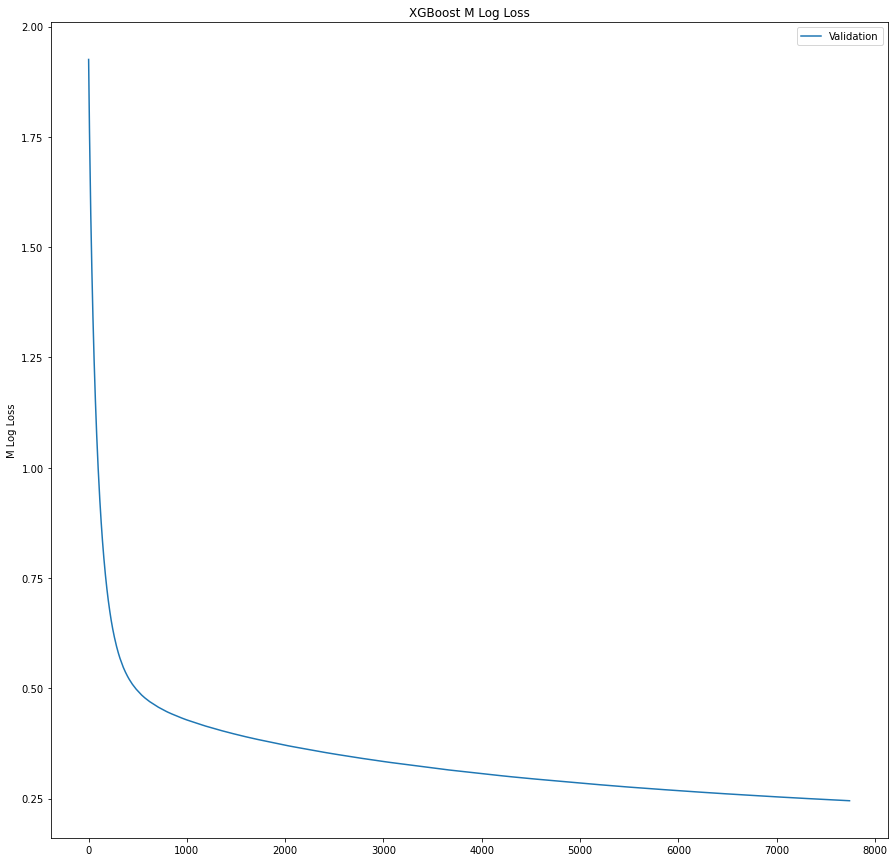

In [15]:
from matplotlib import pyplot

# retrieve performance metrics
results = brain.evals_result()

epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots(figsize=(15,15))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Validation')
ax.legend()
pyplot.ylabel('M Log Loss')
pyplot.title('XGBoost M Log Loss')
pyplot.show()